In [1]:
import warnings
warnings.filterwarnings('ignore')  # <-- this will get rid of runtime errors

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss, recall_score


In [2]:
npz = np.load('/Users/shahzadiaiman/.cache/kagglehub/datasets/saurabhbagchi/ship-and-iceberg-images/versions/1/input_data.npz')

X = npz['X_train']
y = npz['Y_train']
del npz

print(f"We have {y.shape[0]} examples to work with.")
print("X shape:", X.shape)
print("y shape:", y.shape)


We have 4113 examples to work with.
X shape: (4113, 75, 75, 3)
y shape: (4113,)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [4]:
# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Normalize pixel values to 0–1
X_train_flat = X_train_flat / 255.0
X_test_flat = X_test_flat / 255.0

print("Flattened training shape:", X_train_flat.shape)
print("Flattened testing shape:", X_test_flat.shape)


Flattened training shape: (3290, 16875)
Flattened testing shape: (823, 16875)


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat.astype(np.float64))
X_test_scaled = scaler.transform(X_test_flat.astype(np.float64))


In [6]:
def train_test_LR(X_train, y_train, X_test, y_test, c=1):
    """
    Fit a Logistic Regression classifier to the training data.
    Return accuracy, log loss, and recall on the test set.
    """
    model = LogisticRegression(C=c, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    loss = log_loss(y_test, y_prob)
    rec = recall_score(y_test, y_pred)  # binary classification; use average='macro' if multi-class

    return acc, loss, rec


In [7]:
acc, loss, rec = train_test_LR(X_train_scaled, y_train, X_test_scaled, y_test)
print("Accuracy:", acc)
print("Loss:", loss)
print("Recall: ", rec)


Accuracy: 0.6998784933171325
Loss: 1.8567117661553352
Recall:  0.6317073170731707


In [8]:
cs = np.logspace(-3, 3, 10)
recalls = []
accuracies = []
log_losses = []

for c in cs:
    acc, loss, rec = train_test_LR(X_train_scaled, y_train, X_test_scaled, y_test, c=c)
    accuracies.append(acc)
    log_losses.append(loss)
    recalls.append(rec)
    print(f"C={c:.3f} | Recall={rec:.4f} | Accuracy={acc:.4f} | Loss={loss:.4f}")


C=0.001 | Recall=0.6683 | Accuracy=0.7266 | Loss=0.6032
C=0.005 | Recall=0.6415 | Accuracy=0.7169 | Loss=0.7384
C=0.022 | Recall=0.6195 | Accuracy=0.7060 | Loss=0.9284
C=0.100 | Recall=0.6122 | Accuracy=0.6999 | Loss=1.1754
C=0.464 | Recall=0.6195 | Accuracy=0.6950 | Loss=1.5454
C=2.154 | Recall=0.6366 | Accuracy=0.7060 | Loss=2.3572
C=10.000 | Recall=0.6268 | Accuracy=0.7011 | Loss=2.6874
C=46.416 | Recall=0.6268 | Accuracy=0.6987 | Loss=2.6497
C=215.443 | Recall=0.6268 | Accuracy=0.6987 | Loss=2.6679
C=1000.000 | Recall=0.6268 | Accuracy=0.6987 | Loss=2.6719


In [9]:
best_index = np.argmax(recalls)  # pick the model with highest recall
best_C = cs[best_index]
best_recall = recalls[best_index]
print(f"Best C for Recall: {best_C:.3f} | Recall: {best_recall:.4f}")


Best C for Recall: 0.001 | Recall: 0.6683


In [10]:
final_model = LogisticRegression(C=best_C, max_iter=1000)
final_model.fit(X_train_scaled, y_train)
y_pred = final_model.predict(X_test_scaled)
final_recall = recall_score(y_test, y_pred)

print(f"Final Model Recall: {final_recall:.4f}")

Final Model Recall: 0.6683


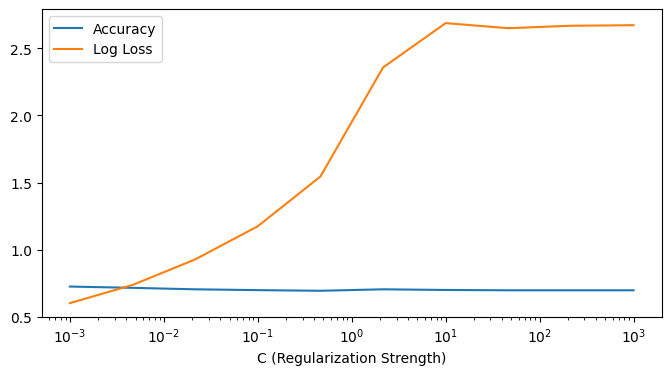

In [11]:
plt.figure(figsize=(8,4))
plt.semilogx(cs, accuracies, label="Accuracy")
plt.semilogx(cs, log_losses, label="Log Loss")
plt.xlabel("C (Regularization Strength)")
plt.legend()
plt.show()


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[324  89]
 [136 274]]


In [14]:
TN, FP, FN, TP = cm.ravel()
TP_percent = TP / (TP + FN) * 100
TN_percent = TN / (TN + FP) * 100

print(f"True Positive % (Icebergs correctly predicted): {TP_percent:.2f}%")
print(f"True Negative % (Ships correctly predicted): {TN_percent:.2f}%")


True Positive % (Icebergs correctly predicted): 66.83%
True Negative % (Ships correctly predicted): 78.45%


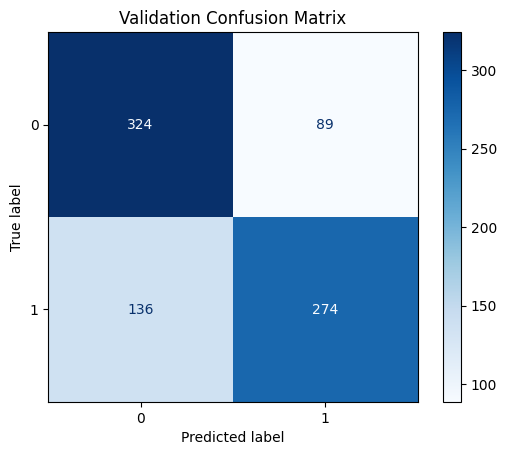

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()

Note:  1 if it is an iceberg, and 0 if it is a ship
